# Import Data

In [ ]:
from numpy.random import seed
seed(7)

import numpy as np
import pandas as pd
from matplotlib import pyplot
  
#import training data
def import_data(path):
  data = pd.read_csv(path,delimiter=',')
  array = data.values
  X = array[:,0:152]
  Y = array[:,152]
  return X,Y


# Data Preprocessing
I can use these separately or build preprocessing into pipeline

In [ ]:
def scalar(X):
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_rescaled = pd.DataFrame(data=scaler.fit_transform(X))
  return X_rescaled

In [ ]:
def standardise(X):
  from sklearn.preprocessing import StandardScaler
  X_standard = pd.DataFrame(StandardScaler().fit_transform(X))
  return X_standard

# Feature Extraction


In [ ]:
#sparse autoencoder with grid search

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

#activity regularizer = sparse. does it go in all layers?
#sparse means uses less nodes so do I need to use more nodes?
def create_autoencoder(activation='relu', code_size = 10, hidden_size=100, kernel_initializer='he_uniform', reg=l1(0.001)):
  input_size = 152 #number of variables
  input_layer = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation=activation, kernel_initializer=kernel_initializer, activity_regularizer=reg)(input_layer)
  code = Dense(code_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=reg)(hidden_1)
  hidden_2 = Dense(hidden_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=reg)(code)
  output_layer = Dense(input_size, activation='sigmoid')(hidden_2)
  autoencoder_regularized = Model(input_layer, output_layer)
  autoencoder_regularized.compile(optimizer='adam',loss='mean_squared_error') #other optimizer and loss function
  return autoencoder_regularized

param_grid = {
    'ae__hidden_size': [50, 100],
    'ae__code_size': [10, 50]
    #'ae__activation':['relu', 'tanh']
    #'ae__kernel_initializer': ['glorot_uniform','normal','uniform','he_uniform'],
    #'ae__reg': [l1(0.001), l2(0.001), l1(10e-6), l2(10e-6)]
    #'ae__epochs': [10, 15, 20],
    #'ae__batch_size':[10, 20, 30]
    #'ae__optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd'],
}

X_train, Y_train = import_data('/content/train_imperson_without4n7_balanced_data.csv')

autoencoder = KerasRegressor(build_fn = create_autoencoder, verbose=0)
steps = []
steps.append(('scaler', MinMaxScaler(feature_range=(0, 1))))
steps.append(('ae', autoencoder))
pipeline = Pipeline(steps=steps)

random_state = 7
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)

grid = GridSearchCV(estimator=pipeline,param_grid=param_grid, cv = kfold, scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(X_train,X_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
  print("%f (%f) with: %r" % (mean,stdev,param))


(97044, 153)
Best: -0.000144 using {'ae__code_size': 50, 'ae__hidden_size': 100}
-0.000409 (0.000074) with: {'ae__code_size': 10, 'ae__hidden_size': 50}
-0.000298 (0.000033) with: {'ae__code_size': 10, 'ae__hidden_size': 100}
-0.000263 (0.000020) with: {'ae__code_size': 50, 'ae__hidden_size': 50}
-0.000144 (0.000018) with: {'ae__code_size': 50, 'ae__hidden_size': 100}


In [ ]:
def best_ae(X):
  activation='relu'
  code_size = 10
  hidden_size = 100
  input_size = 152 #number of variables
  epochs = 5
  batch_size = 10
  kernel_initializer='he_uniform'

  input_layer = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation=activation, kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(input_layer)
  code = Dense(code_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(hidden_1)
  hidden_2 = Dense(hidden_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(code)
  output_layer = Dense(input_size, activation='sigmoid')(hidden_2)

  autoencoder_regularized = Model(input_layer, output_layer)
  autoencoder_regularized.compile(optimizer='adam',loss='mean_squared_error') #other optimizer and loss function
  history_regularized = autoencoder_regularized.fit(X, X, epochs=epochs, batch_size = batch_size, validation_split = 0.2, verbose = 0)

  encoder_regularized = Model(input_layer, code)

  ae_features = pd.DataFrame(encoder_regularized.predict(X))
  return ae_features

**Combine extracted featured combined with original features**
Features from autoencoder code aren't scaled like the input to the autoencoder


In [ ]:
X_train, Y_train = import_data('/content/train_imperson_without4n7_balanced_data.csv')
X_train_scaled = scalar(X_train)
autoencoder_features = best_ae(X_train_scaled)
X_train_combine =  pd.concat([pd.DataFrame(X_train), autoencoder_features], axis=1)  

# Feature selection methods


## Extra Trees Feature Importance

Number of irrelevent features: 75
No: 1, Feature: 48, Score: 0.09392
No: 2, Feature: 64, Score: 0.08686
No: 3, Feature: 70, Score: 0.06530
No: 4, Feature: 47, Score: 0.06192
No: 5, Feature: 65, Score: 0.05364
No: 6, Feature: 44, Score: 0.05260
No: 7, Feature: 68, Score: 0.05211
No: 8, Feature: 6, Score: 0.04436
No: 9, Feature: 79, Score: 0.03782
No: 10, Feature: 61, Score: 0.02979
No: 11, Feature: 156, Score: 0.02975
No: 12, Feature: 158, Score: 0.02694
No: 13, Feature: 35, Score: 0.02414
No: 14, Feature: 63, Score: 0.02365
No: 15, Feature: 153, Score: 0.02208
No: 16, Feature: 151, Score: 0.02182
No: 17, Feature: 157, Score: 0.02051
No: 18, Feature: 5, Score: 0.02017
No: 19, Feature: 155, Score: 0.01297
No: 20, Feature: 107, Score: 0.01274
No: 21, Feature: 142, Score: 0.01251
No: 22, Feature: 161, Score: 0.01197
No: 23, Feature: 143, Score: 0.01156
No: 24, Feature: 95, Score: 0.01085
No: 25, Feature: 67, Score: 0.01047
No: 26, Feature: 105, Score: 0.00974
No: 27, Feature: 152, Score: 0

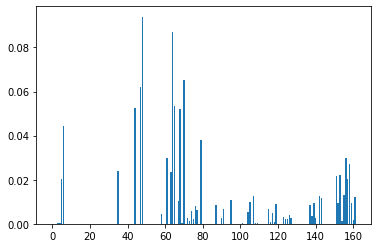

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot

#scaling not needed
# define the model
model = ExtraTreesClassifier()
# fit the model.
model.fit(X_train_combine, Y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
mylist = []
irrel_features = 0
for i,j in enumerate(importance):
  if j > 0:
    mylist.append((i,j))   
  else:
    irrel_features+=1
sorted_list = sorted(mylist, key=lambda x: x[1], reverse=True)

print("Number of irrelevent features: "+str(irrel_features))
for i in range(0,len(sorted_list)):
  print('No: %0d, Feature: %0d, Score: %.5f' % (i+1,sorted_list[i][0],sorted_list[i][1]))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## PCA

[0.17039717 0.3076333  0.41810437 0.48785473 0.5298352  0.56732996
 0.60215226 0.6329306  0.66078251 0.6858658  0.70710483 0.72751268
 0.7452687  0.76169443 0.77719737 0.79259546 0.80652195 0.81943207
 0.83180511 0.84372715 0.85543895 0.86687983 0.87825837 0.88958141
 0.89989513 0.90940187 0.91846304 0.92618853 0.93359688 0.94074414
 0.94732887 0.9532644  0.9589127  0.96363109 0.96812531 0.97242489
 0.9764271  0.98002516 0.98335029 0.98576867 0.98808932 0.99024669
 0.99220126 0.99389986 0.99501864 0.99605486 0.99708262 0.9977915
 0.99840192 0.99877552 0.99901716 0.99918657 0.9993448  0.99945615
 0.99955716 0.99964689 0.99971465 0.99977928 0.99983593 0.99988452
 0.99992075 0.9999512  0.99997294 0.99998665 0.99999375 0.99999764
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.   

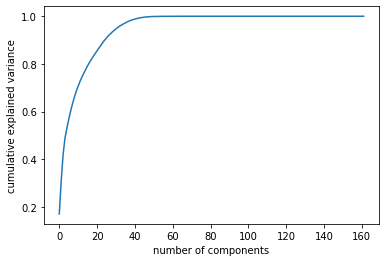

In [ ]:
#PCA Explained Variance

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#PCA is affected by scale and needs to be standardised
X_train_combine_standard = StandardScaler().fit_transform(X_train_combine)
pca = PCA()

pca.fit(X_train_combine_standard)

cumsum = np.cumsum(pca.explained_variance_ratio_)

print(cumsum)

#26 principal components provide explained variance of > 90%

plt.plot(cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_train_combine_standard)

fig = px.scatter(components, x=0, y=1, color=Y_train)
fig.show()


In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_combine_standard)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=Y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
#PCA testing number of components

#Comparing feature selection models

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from numpy import mean
from numpy import std

random_state = 7

#Pipeline contains standardization, PCA and logistic regression classification
def pca_pipe(args):
  steps = list()
  steps.append(('scaler', args[0]))
  steps.append(('selection', args[1]))
  steps.append(('classifier', args[2]))
  pipeline = Pipeline(steps=steps)
  # define the evaluation procedure
  kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
  # evaluate the model using cross-validation
  scores = cross_val_score(pipeline, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
  return scores

mod1 = StandardScaler()
mod2 = PCA(n_components=20)
mod4 = PCA(n_components=10)
mod5 = PCA(n_components=30)
mod6 = PCA(n_components=5)
mod7 = PCA(n_components=15)
mod8 = PCA(n_components=25)
mod3 = LogisticRegression(solver='liblinear')
model1 = (mod1,mod4,mod3)
model2 = (mod1,mod2,mod3)
model3 = (mod1,mod5,mod3)
model4 = (mod1,mod6,mod3)
model5 = (mod1,mod7,mod3)
model6 = (mod1,mod8,mod3)

models = []
models.append(("PCA 5",model4))
models.append(("PCA 10",model1))
models.append(("PCA 15",model5))
models.append(("PCA 20",model2))
models.append(("PCA 25",model6))
models.append(("PCA 30",model3))

results = []
names = []
for name, model in models:
  cv_results = pca_pipe(model)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

PCA 5: 0.932340 (0.012961)
PCA 10: 0.988284 (0.001083)
PCA 15: 0.990180 (0.000710)
PCA 20: 0.990468 (0.000810)
PCA 25: 0.991870 (0.000672)
PCA 30: 0.994291 (0.001044)


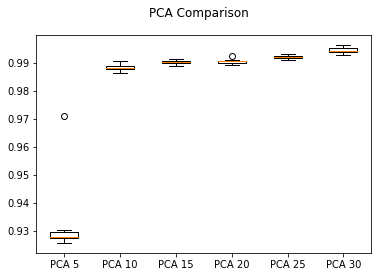

In [ ]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('PCA Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Supervised Classification Algorithms

## Quick model comparison

LR: 0.983574 (0.001411) time: 16.63900327682495 seconds
KNN: 0.999423 (0.000161) time: 15.820446968078613 seconds
CART: 0.999011 (0.000261) time: 16.172385215759277 seconds
NB: 0.876015 (0.003745) time: 12.035104274749756 seconds
SVM linear: 0.990025 (0.000901) time: 201.45902299880981 seconds
SVM RBF: 0.990035 (0.000901) time: 205.2738709449768 seconds


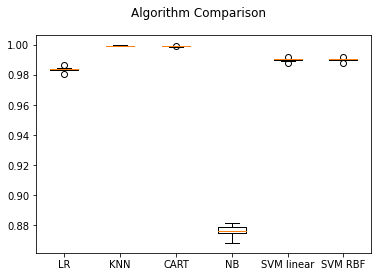

In [ ]:
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import time 

def model_pipe(model):
  steps = list()
  steps.append(('scaler', StandardScaler()))
  steps.append(('selection', PCA(n_components=5)))
  steps.append(('classifier', model))
  pipeline = Pipeline(steps=steps)
  random_state = 7
  # define the evaluation procedure
  kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
  # evaluate the model using cross-validation
  scores = cross_val_score(pipeline, X_train_combine, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
  return scores

models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM linear', SVC()))
models.append(('SVM RBF', SVC(kernel='rbf')))

results = []
names = []

for name, model in models:
  start = time.time()
  cv_results = model_pipe(model)
  finish = time.time()
  training_time = (finish-start)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f) time: %s seconds" % (name, cv_results.mean(), cv_results.std(), training_time)
  print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## MLP Classifier

In [ ]:
#MLP NN with grid search hyperparams

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import numpy
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# fix random seed for reproducibility
numpy.random.seed(7)

#compare models with and without dropout

#create model
def create_model(hidden_size=4, optimizer='rmsprop',init='he_uniform',activation='relu',dropout=0.0):
  model = Sequential()
  model.add(Dense(5,input_dim=5,kernel_initializer=init,activation=activation))
  model.add(Dropout(dropout)) 
  model.add(Dense(hidden_size,kernel_initializer=init,activation=activation))
  model.add(Dropout(dropout))
  model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
  #compile model
  model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model,verbose=0)
steps = list()
steps.append(('standard', StandardScaler()))
steps.append(('selection', PCA(n_components=5)))
steps.append(('scaler', MinMaxScaler(feature_range=(0, 1))))
steps.append(('classifier', model))
pipeline = Pipeline(steps=steps)
   
param_grid = {
    #'classifier__init': ['glorot_uniform','normal','uniform','he_uniform'],
    #'classifier__activation': ['relu','tanh'],
    'classifier__hidden_size':[4, 3, 2],
    'classifier__dropout': [0, 0.2],
    'classifier__optimizer':['RMSprop', 'Adam']
    #'classifier__epochs': [25, 50],
    #'classifier__batch_size':[5, 10, 20]
}

random_state = 7
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)

grid = GridSearchCV(estimator=pipeline,param_grid=param_grid, cv=kfold, n_jobs=-1)

grid_result = grid.fit(X_train_combine,Y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
  print("%f (%f) with: %r" % (mean,stdev,param))


Best: 0.971858 using {'classifier__dropout': 0.2, 'classifier__hidden_size': 4, 'classifier__optimizer': 'Adam'}
0.971611 (0.001535) with: {'classifier__dropout': 0, 'classifier__hidden_size': 4, 'classifier__optimizer': 'RMSprop'}
0.964820 (0.020515) with: {'classifier__dropout': 0, 'classifier__hidden_size': 4, 'classifier__optimizer': 'Adam'}
0.912228 (0.141146) with: {'classifier__dropout': 0, 'classifier__hidden_size': 3, 'classifier__optimizer': 'RMSprop'}
0.924610 (0.141633) with: {'classifier__dropout': 0, 'classifier__hidden_size': 3, 'classifier__optimizer': 'Adam'}
0.916401 (0.137309) with: {'classifier__dropout': 0, 'classifier__hidden_size': 2, 'classifier__optimizer': 'RMSprop'}
0.921276 (0.142581) with: {'classifier__dropout': 0, 'classifier__hidden_size': 2, 'classifier__optimizer': 'Adam'}
0.960349 (0.022645) with: {'classifier__dropout': 0.2, 'classifier__hidden_size': 4, 'classifier__optimizer': 'RMSprop'}
0.971858 (0.002249) with: {'classifier__dropout': 0.2, 'class

# Evaluate
Choose metrics
seaborn library for visualisation

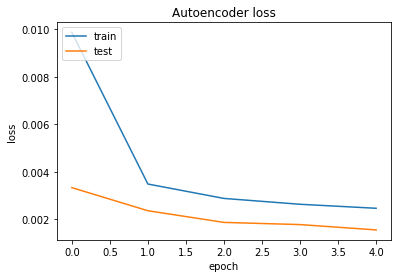

predicted X train features
standardised combined features
predicted X test features
standardised combined features
Test labels
[0. 0. 0. 0. 0.]
prediction labels
[0. 0. 0. 1. 0.]
KNN Classification Report
              precision    recall  f1-score   support

         0.0       0.39      0.64      0.48     20079
         1.0       0.00      0.00      0.00     20079

    accuracy                           0.32     40158
   macro avg       0.20      0.32      0.24     40158
weighted avg       0.20      0.32      0.24     40158

[[12824  7255]
 [20074     5]]
Time taken: 3.05 seconds
ANN trained


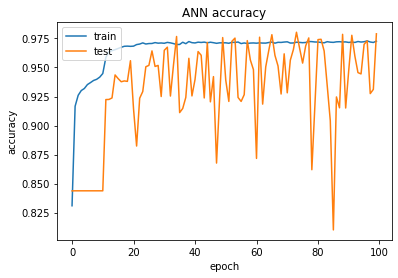

ANN Classification Report
              precision    recall  f1-score   support

         0.0       0.36      0.04      0.07     20079
         1.0       0.49      0.93      0.64     20079

    accuracy                           0.48     40158
   macro avg       0.43      0.48      0.36     40158
weighted avg       0.43      0.48      0.36     40158

[[  838 19241]
 [ 1468 18611]]
Time taken: 395.97 seconds
SVM Classification Report
              precision    recall  f1-score   support

         0.0       0.37      0.58      0.45     20079
         1.0       0.00      0.00      0.00     20079

    accuracy                           0.29     40158
   macro avg       0.18      0.29      0.22     40158
weighted avg       0.18      0.29      0.22     40158

[[11629  8450]
 [20078     1]]
Time taken: 39.93 seconds


In [ ]:
from numpy.random import seed
seed(7)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.svm import SVC
import time

def select_features(X,extracted_features,PCA_components=5):
  X_combine =  pd.concat([pd.DataFrame(X), extracted_features], axis=1) 
  X_combine_standard = standardise(X_combine)
  print("standardised combined features")
  pca = PCA(n_components=PCA_components)
  X_PCA = pca.fit_transform(X_combine_standard)
  return X_PCA

def best_ann(hidden_size=4, optimizer='adam',init='he_uniform',dropout=0.2):
  model = Sequential()
  model.add(Dense(5,input_dim=5,kernel_initializer=init,activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(hidden_size,kernel_initializer=init,activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])  
  return model

def knn_test(X_train_PCA, Y_train, X_test_PCA, Y_test):
  X_train_PCA_standard = standardise(X_train_PCA)
  X_test_PCA_standard = standardise(X_test_PCA)
  start = time.time()
  knnmodel = KNeighborsClassifier()
  knnmodel.fit(X_train_PCA_standard,Y_train)
  Y_knn_pred = knnmodel.predict(X_test_PCA_standard)
  finish = time.time()
  time_taken = finish-start
  report = classification_report(Y_test, Y_knn_pred)
  matrix = confusion_matrix(Y_test, Y_knn_pred)
  print("KNN Classification Report")
  return report, matrix, time_taken

def svm_test(X_train_PCA, Y_train, X_test_PCA, Y_test):
  X_train_PCA_standard = standardise(X_train_PCA)
  X_test_PCA_standard = standardise(X_test_PCA)
  start = time.time()
  svmmodel = SVC()
  svmmodel.fit(X_train_PCA_standard,Y_train)
  
  Y_svm_pred = svmmodel.predict(X_test_PCA_standard)
  finish = time.time()
  time_taken = finish-start
  report = classification_report(Y_test, Y_svm_pred)
  matrix = confusion_matrix(Y_test, Y_svm_pred)
  print("SVM Classification Report")
  return report, matrix, time_taken

def ann_test(X_train_PCA, Y_train, X_test_PCA, Y_test):
  X_train_PCA_scaled = scalar(X_train_PCA)
  X_test_PCA_scaled = scalar(X_test_PCA)
  start = time.time()
  ann_model = best_ann()
  ann_history = ann_model.fit(X_train_PCA_scaled, Y_train, epochs=100, batch_size=20, validation_split = 0.2,verbose=0)
  print("ANN trained")
  Y_pred = (ann_model.predict(X_test_PCA_scaled) > 0.5).astype("int32")
  finish = time.time()
  time_taken = finish-start

  plt.plot(ann_history.history['accuracy'])
  plt.plot(ann_history.history['val_accuracy'])
  plt.title('ANN accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  
  report = classification_report(Y_test, Y_pred)
  matrix = confusion_matrix(Y_test, Y_pred)
  print("ANN Classification Report")
  return report, matrix, time_taken

def main():
  X_train, Y_train = import_data('/content/train_imperson_without4n7_balanced_data.csv')
  X_train_scaled = scalar(X_train)

  activation='relu'
  code_size = 10
  hidden_size = 100
  input_size = 152 #number of variables
  epochs = 5
  batch_size = 10
  kernel_initializer='he_uniform'

  input_layer = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation=activation, kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(input_layer)
  code = Dense(code_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(hidden_1)
  hidden_2 = Dense(hidden_size, activation=activation,kernel_initializer=kernel_initializer, activity_regularizer=l1(0.001))(code)
  output_layer = Dense(input_size, activation='sigmoid')(hidden_2)

  autoencoder_regularized = Model(input_layer, output_layer)
  autoencoder_regularized.compile(optimizer='adam',loss='mean_squared_error') #other optimizer and loss function
  history_regularized = autoencoder_regularized.fit(X_train_scaled, X_train_scaled, epochs=epochs, batch_size = batch_size, validation_split = 0.2, verbose = 0)

  plt.plot(history_regularized.history['loss'])
  plt.plot(history_regularized.history['val_loss'])
  plt.title('Autoencoder loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  encoder_regularized = Model(input_layer, code)

  X_train_ae_features = pd.DataFrame(encoder_regularized.predict(X_train_scaled))
  print("predicted X train features")
  
  X_train_PCA = select_features(X_train, X_train_ae_features)

  X_test, Y_test = import_data('/content/test_imperson_without4n7_balanced_data.csv')
  X_test_scaled = scalar(X_test)
  X_test_ae_features = pd.DataFrame(encoder_regularized.predict(X_test_scaled))
  print("predicted X test features")
  X_test_PCA = select_features(X_test, X_test_ae_features)

  knn_report, knn_matrix, knn_time = knn_test(X_train_PCA, Y_train, X_test_PCA, Y_test)
  print(knn_report)
  print(knn_matrix)
  print('Time taken: %.2f seconds' % knn_time)
  
  ann_report, ann_matrix, ann_time = ann_test(X_train_PCA, Y_train, X_test_PCA, Y_test)
  print(ann_report)
  print(ann_matrix)
  print('Time taken: %.2f seconds' % ann_time)

  svm_report, svm_matrix, svm_time = svm_test(X_train_PCA, Y_train, X_test_PCA, Y_test)
  print(svm_report)
  print(svm_matrix)
  print('Time taken: %.2f seconds' % svm_time)


if __name__ == "__main__":
    main()